## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are their assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [2339]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
import seaborn as sns #plt.style.use(“seaborn”)
%matplotlib inline
from scipy import stats
#from statsmodels.iolib.summary2 import summary_col
#summary_col([reg0,reg1,reg2,reg3,reg4])
#from pandas.core import datetools
#pandas.tseries module

My goal is to create a model that predicts housing prices well even outside of sample.  First I'll read in the train and test data.

In [2340]:
train=pd.read_csv('train.csv')
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [2341]:
test=pd.read_csv('test.csv')
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


Now I'm ready to dive into my data!

### **Data Cleaning**

I will isolate the variables for which over 50% of the observations are grouped in one category.  I classify these variables as dropped and will not include them in my  models.

In [2342]:
dropped = []
for i in train:
   if train[i].dtype == 'object':
       if train[i].value_counts(normalize=True, dropna= False).iloc[0] > .5:
            #print (train[i].value_counts(normalize=True))
            dropped.append(i)

From the documentation provided by Kaggle, I can see that Central Air is a binary variable for whether or not the home has air conditioning.  I don't actually want to drop this because it might be a good indicator of home value and almost certainly more than 50% of homes into either the yes or no category.

In [2343]:
dropped.remove('CentralAir')

I'm also going to put the dropped array into a format that is easier to work with later. 

In [2344]:
dropped=train[['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']]

I carefully look through the documentation and make some determinations about the categorigal and quantitative variables I have to work with.  There are many categorical variables I can productively convert to dummy variables and a few I may be able to convert to meaningful quantitative variables.  Some qualitative variables such as OverallQual follow a Likert scale and already make sense as quantitatve variables.  I will start by converting MSZoning, Utilities, Neighborhood, RoofStyle, RoofMatl, Exterior1st, BsmtFinType1, FireplaceQu into dummy variables. 

In [2345]:
train=pd.get_dummies(train, columns=['MSZoning','Utilities','Neighborhood','RoofStyle',
                                   'RoofMatl','Exterior1st', 'BsmtFinType1','FireplaceQu','PavedDrive','Foundation',
                                     'CentralAir'], 
               prefix=['Zone','Utilities','Neighborhood','RoofStyle','RoofMatl','Exterior','BsmtFinish','FireplaceQu',
                       'Paving','Foundation','CentralAir'])
train.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,Paving_P,Paving_Y,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y
0,1,60,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,1,0,0,1,0,0,0,0,1
1,2,20,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,...,0,1,0,1,0,0,0,0,0,1
2,3,60,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,1,0,0,1,0,0,0,0,1
3,4,70,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,1,1,0,0,0,0,0,0,1
4,5,60,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,...,0,1,0,0,1,0,0,0,0,1


A quick check to see if this worked properly:

In [2346]:
train.BsmtFinish_Rec.value_counts(dropna=False)

0    1327
1     133
Name: BsmtFinish_Rec, dtype: int64

Good!  Now I can take a look at making some of our other categorical variables quantitative.

In [2347]:
train.HouseStyle.value_counts(dropna=False)

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

The most meaningful information I draw from this variable is the number of stories in each home.  Nowhere in our data is this included as its own variable so I will take the opportunity to convert HouseStyle into a quantitative variable that will serve this purpose.  Note that the value counts in the unfinished categories are small.  I will pool these together with their finished counterparts.

In [2348]:
train['HouseStyle'] = train['HouseStyle'].map({'1Story': 1, '1.5Unf': 1.5, '1.5Fin':1.5, '2Story':2,'SFoyer':2,
                                              '2.5Unf':2.5,'2.5Fin':2.5, 'SLvl':2.5})

Here I classify Split-Foyer homes in the same quantitative category as two story homes because they are typically designed with a set of downward stairs and upwards stairs that lead out of the small foyer area into the two main levels of the home.  I likewise classify Split Level Homes (often called "Tri-Level" homes) in the same category as finished 2.5 story homes because they are often three levels with one level significantly smaller than the other two.

Let's see how this looks.

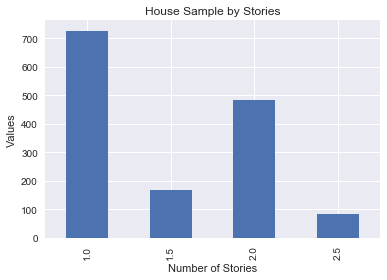

In [2349]:
train['HouseStyle'].value_counts().sort_index().plot(kind='bar',x=[1,1.5,2.0,2.5])
plt.title('House Sample by Stories')
#plt.xticks([1,1.5,2.0,2.5])
plt.ylabel('Values')
plt.xlabel('Number of Stories')

Let's take a look at another variable I considered including.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Many of these categories communicate information about number of stories, which we have already reflected in our HouseStyle variable.  There is also some component of home age communicated in this data but only in broad distinctions (Pre and Post 1945) and this is not consistent across all categories.  For this reason, I will decline to include this variable in my models.

Let's take a look at BsmtQual--

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [2350]:
train.BsmtQual.value_counts(dropna=False)

TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64

I intially considered converting this variable into dummies but because there are no houses in the poor category (in which a house could in theory be anywhere from 1 inch to 69 inches) I think it is reasonable to make this variable quantitative by mapping each category into its minimum height.  I will still create a mapping for poor in case a home outside our train sample includes homes with poor basements, but I don't suspect it will be very common.  Less than 6 feet of basement height is pretty awful.

In [2351]:
train['BsmtQual'] = train['BsmtQual'].map({'Po':60, 'Fa':70, 'TA':80, 'Gd':90,'Ex':100})

In [2352]:
train['BsmtQual']=train['BsmtQual'].fillna(0)

In [2353]:
train['BsmtQual'].value_counts()

80.0     649
90.0     618
100.0    121
0.0       37
70.0      35
Name: BsmtQual, dtype: int64

Now that I've categorized my variables how I like, let's handle missing values.

In [2354]:
#train.isnull().any()
train.columns[train.isnull().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

After cross-checking this list with the list of variables I decided to drop from my regression, I determined that I need to handle missing values for LotFrontage, MasVnrArea, GarageYrBlt, GarageFinish, and BsmtQual.  Taking a glance at the value_counts I decide filling GarageFinish and BsmtQual with the mode and the rest with the mean is reasonable.

In [2355]:
train['GarageFinish']=train['GarageFinish'].fillna(train['GarageFinish'].mode())
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
train['MasVnrArea']=train['MasVnrArea'].fillna(train['MasVnrArea'].mean())
train['GarageYrBlt']=train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

In [2356]:
train['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [2357]:
train=pd.get_dummies(train, columns=['GarageFinish'])

In [2358]:
train['GarageFinish_Unf'].value_counts()

0    855
1    605
Name: GarageFinish_Unf, dtype: int64

Let's check that this cleared up our missing values.

In [2359]:
train['LotFrontage'].isnull().head(20)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: LotFrontage, dtype: bool

In [2360]:
#train.isnull().any()
train.columns[train.isnull().any()].tolist()

['Alley',
 'MasVnrType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

I can also drop the ID column of our data frame since it communicates no useful information for analysis.

In [2361]:
train=train.drop(dropped,axis=1)
train=train.drop('Id',axis=1)

In [2362]:
train.dtypes

MSSubClass             int64
LotFrontage          float64
LotArea                int64
HouseStyle           float64
OverallQual            int64
OverallCond            int64
YearBuilt              int64
YearRemodAdd           int64
Exterior2nd           object
MasVnrArea           float64
BsmtQual             float64
BsmtFinSF1             int64
BsmtFinSF2             int64
BsmtUnfSF              int64
TotalBsmtSF            int64
1stFlrSF               int64
2ndFlrSF               int64
LowQualFinSF           int64
GrLivArea              int64
BsmtFullBath           int64
BsmtHalfBath           int64
FullBath               int64
HalfBath               int64
BedroomAbvGr           int64
KitchenAbvGr           int64
TotRmsAbvGrd           int64
Fireplaces             int64
GarageYrBlt          float64
GarageCars             int64
GarageArea             int64
                      ...   
Exterior_Stone         uint8
Exterior_Stucco        uint8
Exterior_VinylSd       uint8
Exterior_Wd Sd

From checking the data types I see Exterior2nd is still an object.  It also is unlikely to be a huge determinant of home value, but just to cover our bases I'll check its value counts quickly.

In [2363]:
train['Exterior2nd'].value_counts(dropna=False)

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

A large proportion of the observations fall into the VinylSd category so I feel pretty safe dropping this variable from our data frame.

In [2364]:
train=train.drop(['Exterior2nd'],axis=1)

We may also be interested in the presence of outliers in our data.  Let's take a look at the sale prices in our data and determine whether any observations should be dropped before our analysis.

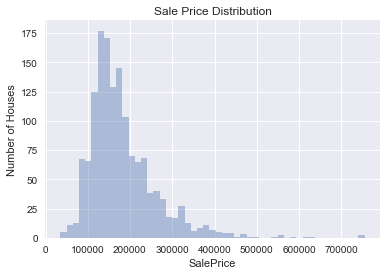

In [2365]:
sns.distplot(train.SalePrice, kde=False) #kde is kernel density estimate
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution')

It appears that most homes in our set close for about 100 to 250 thousand dollars.  We can use scipy tools to remove observations lying further than 3 standard deviations from the mean.

In [2366]:
train=train[(np.abs(stats.zscore(train.SalePrice))<3)]

We can revisualize to see what has changed--

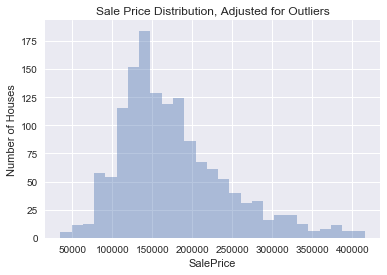

In [2367]:
sns.distplot(train.SalePrice, kde=False) #kde is kernel density estimate
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution, Adjusted for Outliers')

And we observe that homes above $430,000 (roughly) have been dropped.  We are now ready to scale the data.

### **Scaling**

We don't want to scale our sale price so I will split it off of our train dataframe before scaling.

In [2368]:
SalePrice=train['SalePrice']
train=train.drop('SalePrice',axis=1)

In [2369]:
scaler = StandardScaler()
scaler.fit(train) #learns mean and std dev for each variable
scaled_train = scaler.transform(train) #Subtracts mean and divides by std dev.

In [2370]:
train = pd.DataFrame(data=scaled_train, columns=train.columns)

In [2371]:
train.head()

,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,0.069107,-0.218390,-0.196275,1.030758,0.711162,-0.520722,1.068894,0.892656,0.582176,0.438259,...,-0.888007,1.138914,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,1.567396,-0.851012
1,-0.871730,0.468814,-0.080602,-0.918263,-0.038582,2.169571,0.171364,-0.415154,-0.580458,0.438259,...,1.126117,-0.878030,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,1.567396,-0.851012
2,0.069107,-0.080949,0.085362,1.030758,0.711162,-0.520722,1.002410,0.844219,0.380494,0.438259,...,-0.888007,1.138914,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,1.567396,-0.851012
3,0.304316,-0.447458,-0.085632,1.030758,0.711162,-0.520722,-1.856388,-0.705778,-0.580458,-0.225826,...,-0.888007,-0.878030,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,-0.638001,1.175072
4,0.069107,0.652068,0.388122,1.030758,1.460906,-0.520722,0.969168,0.747344,1.495674,0.438259,...,-0.888007,1.138914,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,1.567396,-0.851012


In order to test our predictions we can perform a test-train split on our prepped dataframe.  To work with the outputs of this split in our regressions we will also need to reset our indices.

In [2372]:
X_train, X_test, y_train, y_test = train_test_split(train, SalePrice, test_size=.20, random_state=42)

In [2373]:
y_train=y_train.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)

In [2374]:
y_train.head()

0    129500
1    243000
2     90000
3    225000
4    180000
Name: SalePrice, dtype: int64

In [2375]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,0.657130,-0.722339,-0.317580,1.030758,-0.788326,1.272807,-0.028087,-0.705778,-0.580458,0.438259,...,1.126117,-0.87803,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,-0.638001,1.175072
1,-0.871730,0.652068,0.222660,-0.918263,-0.038582,1.272807,-0.692924,0.795782,-0.580458,-0.225826,...,1.126117,-0.87803,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,-0.638001,1.175072
2,0.774735,-0.447458,-0.322005,-0.918263,-1.538070,-0.520722,-0.726165,-1.674527,-0.580458,-5.538499,...,-0.888007,-0.87803,7.675719,-0.06473,-0.045723,3.759899,-3.759899,-0.55325,-0.638001,1.175072
3,0.069107,2.118102,0.309062,1.030758,0.711162,-0.520722,0.636750,0.311407,0.878766,0.438259,...,1.126117,-0.87803,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,1.567396,-0.851012
4,-0.871730,0.012967,0.080333,-0.918263,-0.038582,-0.520722,0.470541,0.020783,-0.076255,0.438259,...,1.126117,-0.87803,-0.130281,-0.06473,-0.045723,-0.265965,0.265965,-0.55325,-0.638001,1.175072


Beautiful.  We're now ready to begin modeling!

### **Linear Regression**

Now that I've cleaned and grouped a reasonable (and large) set of variables we have to work with let's try and throw all of them into a linear model.  I will first define my regressors.  Because Stats Models doesn't automatically create a regression constant I will manually create one for each regression.

In [2377]:
controls=X_train[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

In [2378]:
controls=sm.add_constant(controls)

In [2379]:
reg = smf.OLS(y_train, controls).fit()
reg.params
reg.summary()
#missing='drop'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     75.26
Date:                Thu, 22 Feb 2018   Prob (F-statistic):               0.00
Time:                        21:11:45   Log-Likelihood:                -13251.
No. Observations:                1150   AIC:                         2.669e+04
Df Residuals:                    1055   BIC:                         2.717e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.754e+05    757.297    231.584      0.000    1.74e+05    1.77e+05
LotFrontage           5556.4736   1025.218      5.420      0.000    3544.775    7568.172
LotArea               5211.5440   1066.219      4.888      0.000    3119.393    7303.695
OverallQual           1.814e+04   1459.598     12.425      0.000    1.53e+04     2.1e+04
OverallCond           6546.5818   1076.749      6.080      0.000    4433.769    8659.394
MasVnrArea            3631.6227    960.137      3.782      0.000    1747.627    5515.619
Foundation_BrkTil    -1499.9551    933.620     -1.607      0.108   -3331.918     332.007
Foundation_CBlock      -61.2616    737.741     -0.083      0.934   -1508.868    1386.345
Foundation_PConc       544.6508    825.184      0.660      0.509   -1074.538    2163.840
Foundation_Slab       1150.0686   1304.919      0.881      0.378   -1410.463    3710.600
Foundation_Stone      1199.4908    722.567      1.660      0.097    -218.341    2617.322
Foundation_Wood       -276.6139    693.956     -0.399      0.690   -1638.306    1085.078
TotalBsmtSF            1.48e+04   1353.976     10.928      0.000    1.21e+04    1.75e+04
Fireplaces            5984.5916   2058.454      2.907      0.004    1945.463       1e+04
CentralAir_Y          1032.4098    977.097      1.057      0.291    -884.865    2949.685
FullBath              8112.1822   1079.853      7.512      0.000    5993.278    1.02e+04
HalfBath              8628.5833    979.628      8.808      0.000    6706.342    1.06e+04
WoodDeckSF            4612.9906    866.169      5.326      0.000    2913.380    6312.601
OpenPorchSF           1945.7846    880.519      2.210      0.027     218.017    3673.552
EnclosedPorch          433.4654    925.496      0.468      0.640   -1382.558    2249.489
ScreenPorch           1215.5974    814.712      1.492      0.136    -383.043    2814.238
PoolArea              1958.7220    770.165      2.543      0.011     447.492    3469.952
MiscVal               -657.3172    742.561     -0.885      0.376   -2114.381     799.747
MoSold                 -94.2366    787.687     -0.120      0.905   -1639.847    1451.374
YrSold               -1287.8271    798.725     -1.612      0.107   -2855.097     279.442
YearBuilt             -467.7691   2528.939     -0.185      0.853   -5430.092    4494.554
YearRemodAdd          3060.9729   1268.647      2.413      0.016     571.614    5550.332
Zone_C (all)         -1148.2479    892.735     -1.286      0.199   -2899.985     603.489
Zone_FV               -916.8425   1417.476     -0.647      0.518   -3698.235    1864.550
Zone_RH                338.9677    838.218      0.404      0.686   -1305.796    1983.732
Zone_RL               2370.4400    729.722      3.248      0.001     938.569    3802.311
Zone_RM              -2017.4412    950.492     -2.123    

We may be overfitting, but let's take a look at the predictions anyway.

In [2380]:
ypred_train = reg.predict(controls) #training error- testing error really matters
ypred_train.head(15)

0     128104.189548
1     176772.521115
2     107370.061587
3     211148.418015
4     197182.108068
5     269340.532763
6     341823.352349
7     133303.862077
8     206520.829407
9     101370.951284
10    137157.830758
11    141569.671235
12    155948.412398
13    317147.797265
14     92876.728780
dtype: float64

These seem like reasonable predictions for home prices.  Let's check our RMSE.

In [2381]:
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,ypred_train))))

Train RMSE: 24426.656229973556


This is a pretty high value for RMSE.  Let's how it holds up out of sample.  One way we can try to fix the high variance we're seeing is by taking out some of our control variables.

In [2382]:
controls_test=X_test[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

In [2383]:
controls_test=sm.add_constant(controls_test)

In [2388]:
controls_test.shape

(288, 102)

In [2384]:
linpred_test=reg.predict(controls_test)
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,linpred_test))))

ValueError: shapes (288,102) and (103,) not aligned: 102 (dim 1) != 103 (dim 0)

In [2302]:
linear_regression_model = SGDRegressor(eta0=.01)
linear_regression_model.fit(controls_test, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [2303]:
linpred_train=reg.predict(controls)
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,linpred_train))))

ValueError: shapes (1150,102) and (103,) not aligned: 102 (dim 1) != 103 (dim 0)

In [2304]:
controls=X_test[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

In [2305]:
linpred_test=reg.predict(controls)
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,linpred_test))))

ValueError: shapes (288,102) and (103,) not aligned: 102 (dim 1) != 103 (dim 0)

In [2098]:
controls=X_test[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]
controls=sm.add_constant(controls)
y_testnew=sm.add_constant(y_test)

In [2216]:
set(X_train.columns).difference(set(X_test.columns))

set()

In [2099]:
ypred_test = reg.predict(controls)
#print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,ypred_test))))

ValueError: shapes (288,102) and (103,) not aligned: 102 (dim 1) != 103 (dim 0)

In [2100]:
controls2=X_train[['LotFrontage', 'LotArea', 'OverallQual','MoSold', 'YrSold', 'YearBuilt','Zone_C (all)','Zone_FV',
                'Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa','Neighborhood_Blmngtn',
                'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr',
                'Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert',
                'Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','BsmtQual']]

In [2101]:
controls2=sm.add_constant(controls2)
reg2 = smf.OLS(endog=y_train, exog=controls2).fit()
reg2.params
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     101.5
Date:                Thu, 22 Feb 2018   Prob (F-statistic):          4.64e-322
Time:                        20:29:24   Log-Likelihood:                -13588.
No. Observations:                1150   AIC:                         2.725e+04
Df Residuals:                    1113   BIC:                         2.744e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.753e+05    984.373    178.083      0.000    1.73e+05    1.77e+05
LotFrontage           5545.9038   1184.521      4.682      0.000    3221.757    7870.051
LotArea               9108.7861   1284.215      7.093      0.000    6589.031    1.16e+04
OverallQual           3.462e+04   1548.005     22.362      0.000    3.16e+04    3.77e+04
MoSold                  32.0065   1004.269      0.032      0.975   -1938.467    2002.480
YrSold                 -64.0784   1004.255     -0.064      0.949   -2034.524    1906.367
YearBuilt             1.083e+04   2307.569      4.695      0.000    6306.355    1.54e+04
Zone_C (all)          -877.8879   1127.853     -0.778      0.437   -3090.845    1335.069
Zone_FV              -2095.8678   1783.258     -1.175      0.240   -5594.794    1403.058
Zone_RH               -898.8636   1057.447     -0.850      0.395   -2973.677    1175.950
Zone_RL               3424.7961    919.426      3.725      0.000    1620.792    5228.800
Zone_RM              -2241.6161   1185.783     -1.890      0.059   -4568.238      85.006
Utilities_AllPub       672.1156    448.033      1.500      0.134    -206.969    1551.200
Utilities_NoSeWa      -672.1156    448.033     -1.500      0.134   -1551.200     206.969
Neighborhood_Blmngtn -2182.7841   1082.410     -2.017      0.044   -4306.578     -58.990
Neighborhood_Blueste  -394.9196    892.738     -0.442      0.658   -2146.558    1356.719
Neighborhood_BrDale  -3577.3376   1110.954     -3.220      0.001   -5757.138   -1397.537
Neighborhood_BrkSide   902.8654   1231.051      0.733      0.463   -1512.577    3318.308
Neighborhood_ClearCr  1667.6495   1070.386      1.558      0.120    -432.552    3767.851
Neighborhood_CollgCr -2320.6942   1097.017     -2.115      0.035   -4473.149    -168.239
Neighborhood_Crawfor  6570.0453   1043.864      6.294      0.000    4521.882    8618.209
Neighborhood_Edwards -5045.7678    995.702     -5.068      0.000   -6999.433   -3092.103
Neighborhood_Gilbert -3359.2755   1066.557     -3.150      0.002   -5451.965   -1266.586
Neighborhood_IDOTRR  -2106.0226   1427.595     -1.475      0.140   -4907.103     695.058
Neighborhood_MeadowV -1238.7600   1118.018     -1.108      0.268   -3432.420     954.900
Neighborhood_Mitchel -3131.0729    977.627     -3.203      0.001   -5049.272   -1212.874
Neighborhood_NAmes   -3880.0425    967.913     -4.009      0.000   -5779.182   -1980.903
Neighborhood_NPkVill -1996.6922    940.857     -2.122      0.034   -3842.746    -150.638
Neighborhood_NWAmes  -1322.0935    955.282     -1.384      0.167   -3196.451     552.264
Neighborhood_NoRidge  9888.3472   1005.970      9.830      0.000    7914.535    1.19e+04
Neighborhood_NridgHt  8542.5767   1126.236      7.585      0.000    6332.791    1.08e+04
Neighborhood_OldTown  -239.7046   1688.470     -0.142    

In [2102]:
ypred2 = reg2.predict(controls2)
ypred2.head(15)

0     128713.143410
1     155268.812051
2      83531.113194
3     225469.112168
4     183993.331555
5     262590.032068
6     346803.594358
7     122525.880848
8     205756.992287
9     130222.814766
10    135952.984710
11    150443.513667
12    162019.930090
13    311838.247903
14     74935.724128
dtype: float64

In [2103]:
np.sqrt(mean_squared_error(y_train,ypred2))

32760.816473749415

This was not very effective.  In fact, this regression gives us an even higher RMSE.  We're going to have to do something more sophisticated to get to the bottom of this problem.  Let's explore regularization.

### **Tuning with Lasso**

In [2104]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

Now that we've moved over into SK Learn packages, I don't need to worry about adding a constant to my controls.  I'm just going to define controls for my training set and for my testing set separately using the columns from the first regression we ran in my linear model.

In [2105]:
controls_train=X_train[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

Using LassoCV we can run our model using the optimal alpha value out of the 100 alphas tested for by the function.  Let's see where this gets us.

In [2106]:
lasso_reg=linear_model.LassoCV()
lasso_reg.fit(controls_train,y_train)
#lasso_reg.get_params()

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [2107]:
lasso_reg.score(controls_train,y_train)

0.85702188653372124

In [2108]:
controls_test=X_test[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

Now we can run our predictions for both the training set and the testing set and obtain our RMSE's.  The test RMSE is more important because it measures how well our model performs out of sample.

In [2109]:
lassopred_train=lasso_reg.predict(controls_train)
lassopred_test=lasso_reg.predict(controls_test)

In [2110]:
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,lassopred_train))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,lassopred_test))))

Train RMSE: 25639.207417148533
Test RMSE: 27322.021096749784


These values are still not super good.  Let's try another tuning method.

### **Tuning with Elastic Net**

In [2111]:
elastic_reg=linear_model.ElasticNet()
elastic_reg.fit(controls_train,y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [2112]:
elastic_reg.score(controls_train,y_train)

0.84408652996129307

In [2113]:
elasticpred_train=elastic_reg.predict(controls_train)
elasticpred_test=elastic_reg.predict(controls_test)

In [2114]:
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,elasticpred_train))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,elasticpred_test))))

Train RMSE: 26773.899768276013
Test RMSE: 27932.826267556768


This is about the same.  Let's take one more shot at tuning this linear model.

### **Tuning with Ridge**

In [2115]:
ridge_reg=linear_model.RidgeCV()
ridge_reg.fit(controls_train,y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [2116]:
ridgepred_train=ridge_reg.predict(controls_train)
ridgepred_test=ridge_reg.predict(controls_test)

In [2117]:
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,ridgepred_train))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test,ridgepred_test))))

Train RMSE: 24590.939180165697
Test RMSE: 27424.791228947273


Looks like Lasso performed the best out of the tuning methods.  While this did provide a marginal improvement, I'm interested to see what another model has to offer.

### **Logistic Regression**

In [2118]:
from sklearn.linear_model import LogisticRegression

### **K-Nearest Neighbors**

In [2119]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [2120]:
kn_reg = KNeighborsRegressor()
gridsearch = GridSearchCV(kn_reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(controls_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(controls_train)
y_pred_test = gridsearch.predict(controls_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train MSE: 29952.17391304348	Test MSE: 1382888019.8745418
